
# [Lux AI] Working Title Bot
The code structure and logic, and version updates are elaborated in the comment section.

I hope this can be a useful template for you to work on your bot on.
You are recommended to edit on a clone/fork of [my repository](https://github.com/tonghuikang/lux-ai-2021) with your favorite IDE.
You can submit the zip the repository to the competition. This notebook is generated with `generate_notebook.py`.

Regardless, do feel free to clone this notebook and submit `submission.tar.gz` under the "Data" tab.


In [1]:
!pip install kaggle-environments -U > /dev/null
!cp -r ../input/lux-ai-2021/* .

# Agent Logic
The following scipts contain the algorithms that the agent uses.
The algorithm is described in the comments.
Feel free to ask for more clarification.


In [2]:
%%writefile agent.py
import os
import time
import pickle

import builtins as __builtin__

from lux.game import Game, Missions

from make_actions import make_city_actions, make_unit_missions, make_unit_actions
from make_annotations import annotate_game_state, annotate_missions, annotate_movements

game_state = Game()
missions = Missions()


def game_logic(game_state: Game, missions: Missions, DEBUG=False):
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    game_state.calculate_features(missions)
    state_annotations = annotate_game_state(game_state)
    actions_by_cities = make_city_actions(game_state, missions, DEBUG=DEBUG)
    missions = make_unit_missions(game_state, missions, DEBUG=DEBUG)
    mission_annotations = annotate_missions(game_state, missions)
    missions, actions_by_units = make_unit_actions(game_state, missions, DEBUG=DEBUG)
    movement_annotations = annotate_movements(game_state, actions_by_units)

    print("actions_by_cities", actions_by_cities)
    print("actions_by_units", actions_by_units)
    print("mission_annotations", mission_annotations)
    print("movement_annotations", movement_annotations)
    actions = actions_by_cities + actions_by_units + mission_annotations + movement_annotations + state_annotations
    return actions, game_state, missions


def agent(observation, configuration, DEBUG=False):
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    del configuration  # unused
    global game_state, missions

    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state.player_id = observation.player
        game_state._update(observation["updates"][2:])
        game_state.fix_iteration_order()
    else:
        # actually rebuilt and recomputed from scratch
        game_state._update(observation["updates"])

    if not os.environ.get('GFOOTBALL_DATA_DIR', ''):  # on Kaggle compete, do not save items
        str_step = str(observation["step"]).zfill(3)
        with open('snapshots/observation-{}-{}.pkl'.format(str_step, game_state.player_id), 'wb') as handle:
            pickle.dump(observation, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('snapshots/game_state-{}-{}.pkl'.format(str_step, game_state.player_id), 'wb') as handle:
            pickle.dump(game_state, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('snapshots/missions-{}-{}.pkl'.format(str_step, game_state.player_id), 'wb') as handle:
            pickle.dump(missions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    game_state.compute_start_time = time.time()
    actions, game_state, missions = game_logic(game_state, missions)
    return actions


Overwriting agent.py


In [3]:
%%writefile make_actions.py
# functions executing the actions

import builtins as __builtin__
from typing import Tuple, List

from lux.game import Game, Mission, Missions
from lux.game_objects import CityTile, Unit
from lux.game_position import Position
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS

from heuristics import find_best_cluster

DIRECTIONS = Constants.DIRECTIONS


def make_city_actions(game_state: Game, missions: Missions, DEBUG=False) -> List[str]:
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    player = game_state.player
    missions.cleanup(player,
                     game_state.player_city_tile_xy_set,
                     game_state.opponent_city_tile_xy_set,
                     game_state.convolved_collectable_tiles_xy_set)
    game_state.repopulate_targets(missions)

    units_cap = sum([len(x.citytiles) for x in player.cities.values()])
    units_cnt = len(player.units)  # current number of units

    actions: List[str] = []

    def do_research(city_tile: CityTile):
        action = city_tile.research()
        game_state.player.research_points += 1
        actions.append(action)

    def build_workers(city_tile: CityTile):
        nonlocal units_cnt
        action = city_tile.build_worker()
        actions.append(action)
        units_cnt += 1

    city_tiles: List[CityTile] = []
    for city in player.cities.values():
        for city_tile in city.citytiles:
            city_tiles.append(city_tile)
    if not city_tiles:
        return []

    city_tiles.sort(key=lambda city_tile:
        (city_tile.pos.x*game_state.x_order_coefficient, city_tile.pos.y*game_state.y_order_coefficient))

    for city_tile in city_tiles:
        if not city_tile.can_act():
            continue

        unit_limit_exceeded = (units_cnt >= units_cap)

        cluster_leader = game_state.xy_to_resource_group_id.find(tuple(city_tile.pos))
        cluster_unit_limit_exceeded = \
            game_state.xy_to_resource_group_id.get_point(tuple(city_tile.pos)) <= len(game_state.resource_leader_to_locating_units[cluster_leader])
        if cluster_unit_limit_exceeded:
            print("unit_limit_exceeded", city_tile.cityid, tuple(city_tile.pos))

        if player.researched_uranium() and unit_limit_exceeded:
            print("skip city", city_tile.cityid, tuple(city_tile.pos))
            continue

        if not player.researched_uranium() and game_state.turns_to_night < 3:
            print("research and dont build units at night", tuple(city_tile.pos))
            do_research(city_tile)
            continue

        nearest_resource_distance = game_state.distance_from_collectable_resource[city_tile.pos.y, city_tile.pos.x]
        travel_range = game_state.turns_to_night // GAME_CONSTANTS["PARAMETERS"]["UNIT_ACTION_COOLDOWN"]["WORKER"]
        resource_in_travel_range = nearest_resource_distance < travel_range

        if resource_in_travel_range and not unit_limit_exceeded and not cluster_unit_limit_exceeded:
            print("build_worker", city_tile.cityid, city_tile.pos.x, city_tile.pos.y, nearest_resource_distance, travel_range)
            build_workers(city_tile)
            continue

        if not player.researched_uranium():
            print("research", tuple(city_tile.pos))
            do_research(city_tile)
            continue

        # otherwise don't do anything

    return actions


def make_unit_missions(game_state: Game, missions: Missions, DEBUG=False) -> Missions:
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    player = game_state.player
    missions.cleanup(player,
                     game_state.player_city_tile_xy_set,
                     game_state.opponent_city_tile_xy_set,
                     game_state.convolved_collectable_tiles_xy_set)

    unit_ids_with_missions_assigned_this_turn = set()

    player.units.sort(key=lambda unit:
        (unit.pos.x*game_state.x_order_coefficient, unit.pos.y*game_state.y_order_coefficient, unit.encode_tuple_for_cmp()))

    for unit in player.units:
        # mission is planned regardless whether the unit can act
        current_mission: Mission = missions[unit.id] if unit.id in missions else None
        current_target_position = current_mission.target_position if current_mission else None

        # avoid sharing the same target
        game_state.repopulate_targets(missions)

        # if the unit is waiting for dawn at the side of resource
        stay_up_till_dawn = (unit.get_cargo_space_left() <= 4 and (not game_state.is_day_time or game_state.turn%40 == 0))
        # if the unit is full and it is going to be day the next few days
        # go to an empty tile and build a citytile
        # print(unit.id, unit.get_cargo_space_left())
        if unit.get_cargo_space_left() == 0 or stay_up_till_dawn:
            nearest_position, distance_with_features = game_state.get_nearest_empty_tile_and_distance(unit.pos, current_target_position)
            if stay_up_till_dawn or distance_with_features[0] * 2 <= game_state.turns_to_night - 2:
                print("plan mission to build citytile", unit.id, unit.pos, "->", nearest_position)
                mission = Mission(unit.id, nearest_position, unit.build_city())
                missions.add(mission)
                continue

        if unit.id in missions:
            mission: Mission = missions[unit.id]
            if mission.target_position == unit.pos:
                # take action and not make missions if already at position
                continue

        if unit.id in missions:
            # the mission will be recaluated if the unit fails to make a move after make_unit_actions
            continue

        best_position, best_cell_value = find_best_cluster(game_state, unit, DEBUG=DEBUG)
        # [TODO] what if best_cell_value is zero
        distance_from_best_position = game_state.retrieve_distance(unit.pos.x, unit.pos.y, best_position.x, best_position.y)
        print("plan mission adaptative", unit.id, unit.pos, "->", best_position)
        mission = Mission(unit.id, best_position, None)
        missions.add(mission)
        unit_ids_with_missions_assigned_this_turn.add(unit.id)

        # [TODO] when you can secure a city all the way to the end of time, do it

        # [TODO] just let units die perhaps

    return missions


def make_unit_actions(game_state: Game, missions: Missions, DEBUG=False) -> Tuple[Missions, List[str]]:
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    player, opponent = game_state.player, game_state.opponent
    actions = []

    units_with_mission_but_no_action = set(missions.keys())
    prev_actions_len = -1

    # repeat attempting movements for the units until no additional movements can be added
    while prev_actions_len < len(actions):
      prev_actions_len = len(actions)

      for unit in player.units:
        if not unit.can_act():
            units_with_mission_but_no_action.discard(unit.id)
            continue

        # if there is no mission, continue
        if unit.id not in missions:
            units_with_mission_but_no_action.discard(unit.id)
            continue

        mission: Mission = missions[unit.id]
        print("attempting action for", unit.id, unit.pos, "->", mission.target_position)

        # if the location is reached, take action
        if unit.pos == mission.target_position:
            units_with_mission_but_no_action.discard(unit.id)
            print("location reached and make action", unit.id, unit.pos)
            action = mission.target_action

            # do not build city at last light
            if action and action[:5] == "bcity" and game_state.turn%40 == 30:
                del missions[unit.id]
                continue

            if action:
                actions.append(action)
            del missions[unit.id]
            continue

        # attempt to move the unit
        direction = attempt_direction_to(game_state, unit, mission.target_position)
        if direction != "c":
            units_with_mission_but_no_action.discard(unit.id)
            action = unit.move(direction)
            print("make move", unit.id, unit.pos, direction, unit.pos.translate(direction, 1))
            actions.append(action)
            continue

        # [TODO] make it possible for units to swap positions

    # if the unit is not able to make an action, delete the mission
    for unit_id in units_with_mission_but_no_action:
        mission: Mission = missions[unit_id]
        mission.delays += 1
        if mission.delays >= 1:
            del missions[unit_id]

    return missions, actions


def attempt_direction_to(game_state: Game, unit: Unit, target_pos: Position) -> DIRECTIONS:

    smallest_cost = [2,2,2,2]
    closest_dir = DIRECTIONS.CENTER
    closest_pos = unit.pos

    for direction in game_state.dirs:
        newpos = unit.pos.translate(direction, 1)

        cost = [0,0,0,0]

        # do not go out of map
        if tuple(newpos) in game_state.xy_out_of_map:
            continue

        # discourage if new position is occupied, not your city tile and not your current position
        if tuple(newpos) in game_state.occupied_xy_set:
            if tuple(newpos) not in game_state.player_city_tile_xy_set:
                if tuple(newpos) != tuple(unit.pos):
                    cost[0] = 3

        # discourage going into a city tile if you are carrying substantial wood
        if tuple(newpos) in game_state.player_city_tile_xy_set and unit.cargo.wood >= 60:
            cost[0] = 1

        # path distance as main differentiator
        path_dist = game_state.retrieve_distance(newpos.x, newpos.y, target_pos.x, target_pos.y)
        cost[1] = path_dist

        # manhattan distance to tie break
        manhattan_dist = (newpos - target_pos)
        cost[2] = manhattan_dist

        # prefer to walk on tiles with resources
        aux_cost = game_state.convolved_collectable_tiles_matrix[newpos.y, newpos.x]
        cost[3] = -aux_cost

        # if starting from the city, consider manhattan distance instead of path distance
        if tuple(unit.pos) in game_state.player_city_tile_xy_set:
            cost[1] = manhattan_dist

        # update decision
        if cost < smallest_cost:
            smallest_cost = cost
            closest_dir = direction
            closest_pos = newpos

    if closest_dir != DIRECTIONS.CENTER:
        game_state.occupied_xy_set.discard(tuple(unit.pos))
        if tuple(closest_pos) not in game_state.player_city_tile_xy_set:
            game_state.occupied_xy_set.add(tuple(closest_pos))
        unit.cooldown += 2

    return closest_dir


Writing make_actions.py


In [4]:
%%writefile make_annotations.py
import time
from itertools import chain
from typing import List

import builtins as __builtin__

from lux.game import Game, Mission, Missions, Player, Unit
import lux.annotate as annotate


def annotate_game_state(game_state: Game, DEBUG=False):
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    print("Turn number: ", game_state.turn)
    print("Citytile count: ", game_state.player.city_tile_count)
    print("Unit count: ", len(game_state.player.units))

    if game_state.player_id == 1:
        # reduce clutter for mirror matchup
        return []

    annotations = []

    for city in chain(game_state.player.cities.values(), game_state.opponent.cities.values()):
        for citytile in city.citytiles:
            if city.night_fuel_duration >= game_state.night_turns_left:
                annotation = annotate.circle(citytile.pos.x, citytile.pos.y)
                annotations.append(annotation)
            else:
                annotation = annotate.text(citytile.pos.x, citytile.pos.y, str(city.night_fuel_duration), 50)
                annotations.append(annotation)


    for unit in chain(game_state.player.units, game_state.opponent.units):
        if unit.cargo.get_shorthand():
            annotation = annotate.text(unit.pos.x, unit.pos.y, unit.cargo.get_shorthand(), 50)
            annotations.append(annotation)

    # you can also read the pickled game_state and print its attributes
    return annotations


def annotate_missions(game_state: Game, missions: Missions, DEBUG=False):
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    print("Missions")
    print(missions)
    # you can also read the pickled missions and print its attributes

    annotations: List[str] = []
    player: Player = game_state.player

    for unit_id, mission in missions.items():
        mission: Mission = mission
        unit: Unit = player.units_by_id[unit_id]

        annotation = annotate.line(unit.pos.x, unit.pos.y, mission.target_position.x, mission.target_position.y)
        annotations.append(annotation)

        if mission.target_action and mission.target_action.split(" ")[0] == "bcity":
            annotation = annotate.circle(mission.target_position.x, mission.target_position.y)
            annotations.append(annotation)
        else:
            annotation = annotate.x(mission.target_position.x, mission.target_position.y)
            annotations.append(annotation)

    annotation = annotate.sidetext("Unit Count: {}-{} Citytiles: {}-{} Groups: {}/{} Runtime: {:.3f}".format(
        len(game_state.player.units), len(game_state.opponent.units),
        len(game_state.player_city_tile_xy_set), len(game_state.opponent_city_tile_xy_set),
        game_state.targeted_cluster_count, game_state.xy_to_resource_group_id.get_group_count(),
        time.time() - game_state.compute_start_time))
    annotations.append(annotation)

    return annotations


def annotate_movements(game_state: Game, actions_by_units: List[str]):
    annotations = []
    dirs = game_state.dirs
    d5 = game_state.dirs_dxdy

    for action_by_units in actions_by_units:
        if action_by_units[:2] != "m ":
            continue
        unit_id, dir = action_by_units.split(" ")[1:]
        unit = game_state.player.units_by_id[unit_id]
        x, y = unit.pos.x, unit.pos.y
        dx, dy = d5[dirs.index(dir)]
        annotation = annotate.line(x, y, x+dx, y+dy)
        annotations.append(annotation)

    return annotations


Writing make_annotations.py


In [5]:
%%writefile heuristics.py
# contains designed heuristics
# which could be fine tuned

import numpy as np
import builtins as __builtin__

from typing import List
from lux import game

from lux.game import Game, Unit
from lux.game_map import Cell, RESOURCE_TYPES
from lux.constants import Constants
from lux.game_position import Position
from lux.game_constants import GAME_CONSTANTS


def find_best_cluster(game_state: Game, unit: Unit, distance_multiplier = -0.5, DEBUG=False):
    if DEBUG: print = __builtin__.print
    else: print = lambda *args: None

    # passing game_state attributes to compute travel range
    unit.compute_travel_range((game_state.turns_to_night, game_state.turns_to_dawn, game_state.is_day_time),)

    # for debugging
    score_matrix_wrt_pos = game_state.init_matrix()

    # default response is not to move
    best_position = unit.pos
    best_cell_value = (0,0,0,0)

    # only consider other cluster if the current cluster has more than one agent mining
    consider_different_cluster = False
    # must consider other cluster if the current cluster has more agent than tiles
    consider_different_cluster_must = False

    # calculate how resource tiles and how many units on the current cluster
    current_leader = game_state.xy_to_resource_group_id.find(tuple(unit.pos))
    units_mining_on_current_cluster = game_state.resource_leader_to_locating_units[current_leader] & game_state.resource_leader_to_targeting_units[current_leader]
    if len(units_mining_on_current_cluster) >= 1:
        consider_different_cluster = True
    resource_size_of_current_cluster = game_state.xy_to_resource_group_id.get_point(current_leader)
    if len(units_mining_on_current_cluster) >= resource_size_of_current_cluster:
        consider_different_cluster_must = True

    for y in game_state.y_iteration_order:
        for x in game_state.x_iteration_order:

            # what not to target
            if (x,y) in game_state.targeted_xy_set:
                continue
            if (x,y) in game_state.targeted_for_building_xy_set:
                continue
            if (x,y) in game_state.opponent_city_tile_xy_set:
                continue
            if (x,y) in game_state.player_city_tile_xy_set:
                continue

            # cluster targeting logic
            target_bonus = 1
            target_leader = game_state.xy_to_resource_group_id.find((x,y))
            if consider_different_cluster or consider_different_cluster_must:
                # if the target is a cluster and not the current cluster
                if target_leader and target_leader != current_leader:

                    units_targeting_or_mining_on_target_cluster = \
                        game_state.resource_leader_to_locating_units[target_leader] | \
                        game_state.resource_leader_to_targeting_units[target_leader]

                    # target bonus depends on how many resource tiles and how many units that are mining or targeting
                    if len(units_targeting_or_mining_on_target_cluster) == 0:
                        target_bonus = game_state.xy_to_resource_group_id.get_point(target_leader)/\
                                       (1 + len(game_state.resource_leader_to_locating_units[target_leader] &
                                                game_state.resource_leader_to_targeting_units[target_leader]))

                    if consider_different_cluster_must:
                        target_bonus = target_bonus * 100

            elif target_leader == current_leader:
                target_bonus = 2

            # prefer empty tile because you can build afterwards quickly
            empty_tile_bonus = 1/(0.5+game_state.distance_from_buildable_tile[y,x])

            # no empty tile preference if resource is not wood
            for dx,dy in game_state.dirs_dxdy:
                xx, yy = x+dx, y+dy
                if (xx,yy) in game_state.wood_exist_xy_set:
                    break
            else:
                empty_tile_bonus = 1/(0.5+max(1,game_state.distance_from_buildable_tile[y,x]))

            # scoring function
            if game_state.convolved_collectable_tiles_matrix[y,x] > 0:
                # using path distance
                distance = game_state.retrieve_distance(unit.pos.x, unit.pos.y, x, y)
                distance = max(0.5, distance)  # prevent zero error

                # estimate target score
                if distance <= unit.travel_range:
                    cell_value = (target_bonus,
                                  empty_tile_bonus * game_state.convolved_collectable_tiles_matrix[y,x] * distance ** distance_multiplier,
                                  game_state.distance_from_edge[y,x],
                                  -game_state.distance_from_opponent_assets[y,x])
                    score_matrix_wrt_pos[y,x] = cell_value[0]*1000 + cell_value[1]*100 + cell_value[2]*10 + cell_value[3]

                    # update best target
                    if cell_value > best_cell_value:
                        best_cell_value = cell_value
                        best_position = Position(x,y)

    # for debugging
    game_state.heuristics_from_positions[tuple(unit.pos)] = score_matrix_wrt_pos

    return best_position, best_cell_value


Writing heuristics.py


In [6]:
%%writefile main.py
from typing import Dict
import sys
from agent import agent
if __name__ == "__main__":

    def read_input():
        """
        Reads input from stdin
        """
        try:
            return input()
        except EOFError as eof:
            raise SystemExit(eof)
    step = 0
    class Observation(Dict[str, any]):
        def __init__(self, player=0) -> None:
            self.player = player
            # self.updates = []
            # self.step = 0
    observation = Observation()
    observation["updates"] = []
    observation["step"] = 0
    player_id = 0
    while True:
        inputs = read_input()
        observation["updates"].append(inputs)

        if step == 0:
            player_id = int(observation["updates"][0])
            observation.player = player_id
        if inputs == "D_DONE":
            actions = agent(observation, None)
            observation["updates"] = []
            step += 1
            observation["step"] = step
            print(",".join(actions))
            print("D_FINISH")


Overwriting main.py


# Upgraded Game Kit
The game kit has been edited to include more features for the agent to make decisions on.


In [7]:
%%writefile lux/game.py
import time
import heapq
from collections import defaultdict, deque
from typing import DefaultDict, Dict, List, Tuple, Set

import numpy as np

from .constants import Constants
from .game_map import GameMap, RESOURCE_TYPES
from .game_objects import Player, Unit, City
from .game_position import Position
from .game_constants import GAME_CONSTANTS

INPUT_CONSTANTS = Constants.INPUT_CONSTANTS


class Mission:
    def __init__(self, unit_id: str, target_position: Position, target_action: str = ""):
        self.target_position: Position = target_position
        self.target_action: str = target_action
        self.unit_id: str = unit_id
        self.delays: int = 0
        # [TODO] some expiry date for each mission

    def __str__(self):
        return " ".join([str(self.target_position), self.target_action])


class Missions(defaultdict):
    def __init__(self):
        self: DefaultDict[str, Mission] = defaultdict(Mission)

    def add(self, mission: Mission):
        self[mission.unit_id] = mission

    def cleanup(self, player: Player,
                player_city_tile_xy_set: Set[Tuple],
                opponent_city_tile_xy_set: Set[Tuple],
                convolved_collectable_tiles_xy_set: Set[Tuple]):
        # probably should be a standalone function instead of a method

        for unit_id in list(self.keys()):
            mission: Mission = self[unit_id]

            # if dead, delete from list
            if unit_id not in player.units_by_id:
                del self[unit_id]
                continue

            unit: Unit = player.units_by_id[unit_id]
            # if you want to build city without resource, delete from list
            if mission.target_action and mission.target_action[:5] == "bcity":
                if unit.cargo == 0:
                    del self[unit_id]
                    continue

            # if opponent has already built a base, reconsider your mission
            if tuple(mission.target_position) in opponent_city_tile_xy_set:
                del self[unit_id]
                continue

            # if you are in a base, reconsider your mission
            if tuple(unit.pos) in player_city_tile_xy_set:
                del self[unit_id]
                continue

            # if your target no longer have resource, reconsider your mission
            if tuple(mission.target_position) not in convolved_collectable_tiles_xy_set:
                del self[unit_id]
                continue

    def __str__(self):
        return " ".join([unit_id + " " + str(x) for unit_id,x in self.items()])

    def get_targets(self):
        return [mission.target_position for unit_id, mission in self.items()]

    def get_targets_and_actions(self):
        return [(mission.target_position, mission.target_action) for unit_id, mission in self.items()]


class DisjointSet:
    def __init__(self):
        self.parent = {}
        self.sizes = defaultdict(int)
        self.points = defaultdict(int)  # tracks resource pile size
        self.num_sets = 0

    def find(self, a, point=0):
        if a not in self.parent:
            self.parent[a] = a
            self.sizes[a] += 1
            self.points[a] += point
            self.num_sets += 1
        acopy = a
        while a != self.parent[a]:
            a = self.parent[a]
        while acopy != a:
            self.parent[acopy], acopy = a, self.parent[acopy]
        return a

    def union(self, a, b):
        a, b = self.find(a), self.find(b)
        if a != b:
            if self.sizes[a] < self.sizes[b]:
                a, b = b, a

            self.num_sets -= 1
            self.parent[b] = a
            self.sizes[a] += self.sizes[b]
            self.points[a] += self.points[b]

    def get_size(self, a):
        return self.sizes[self.find(a)]

    def get_point(self, a):
        return self.points[self.find(a)]

    def get_groups(self):
        groups = defaultdict(list)
        for element in self.parent:
            leader = self.find(element)
            if leader:
                groups[leader].append(element)
        return groups

    def get_group_count(self):
        return sum(self.points[leader] > 1 for leader in self.get_groups().keys())


class Game:

    # counted from the time after the objects are saved to disk
    compute_start_time = -1

    def _initialize(self, messages):
        """
        initialize state
        """
        self.player_id: int = int(messages[0])
        self.turn: int = -1
        # get some other necessary initial input
        mapInfo = messages[1].split(" ")
        self.map_width: int = int(mapInfo[0])
        self.map_height: int = int(mapInfo[1])
        self.map: GameMap = GameMap(self.map_width, self.map_height)
        self.players: List[Player] = [Player(0), Player(1)]

        self.x_iteration_order = list(range(self.map_width))
        self.y_iteration_order = list(range(self.map_height))
        self.dirs: List = [
            Constants.DIRECTIONS.NORTH,
            Constants.DIRECTIONS.EAST,
            Constants.DIRECTIONS.SOUTH,
            Constants.DIRECTIONS.WEST,
            Constants.DIRECTIONS.CENTER
        ]
        self.dirs_dxdy: List = [(0,-1), (1,0), (0,1), (-1,0), (0,0)]


    def fix_iteration_order(self):
        '''
        Fix iteration order at initisation to allow moves to be symmetric
        '''
        assert len(self.player.cities) == 1
        assert len(self.opponent.cities) == 1
        px,py = tuple(list(self.player.cities.values())[0].citytiles[0].pos)
        ox,oy = tuple(list(self.opponent.cities.values())[0].citytiles[0].pos)

        flipping = False
        self.y_order_coefficient = 1
        self.x_order_coefficient = 1

        if px == ox:
            if py < oy:
                flipping = True
                self.y_iteration_order = self.y_iteration_order[::-1]
                self.y_order_coefficient = -1
                idx1, idx2 = 0,2
        elif py == oy:
            if px < ox:
                flipping = True
                self.x_iteration_order = self.x_iteration_order[::-1]
                self.x_order_coefficient = -1
                idx1, idx2 = 1,3
        else:
            assert False

        if flipping:
            self.dirs[idx1], self.dirs[idx2] = self.dirs[idx2], self.dirs[idx1]
            self.dirs_dxdy[idx1], self.dirs_dxdy[idx2] = self.dirs_dxdy[idx2], self.dirs_dxdy[idx1]


    def _end_turn(self):
        print("D_FINISH")


    def _reset_player_states(self):
        self.players[0].units = []
        self.players[0].cities = {}
        self.players[0].city_tile_count = 0
        self.players[1].units = []
        self.players[1].cities = {}
        self.players[1].city_tile_count = 0

        self.player: Player = self.players[self.player_id]
        self.opponent: Player = self.players[1 - self.player_id]


    def _update(self, messages):
        """
        update state
        """
        self.map = GameMap(self.map_width, self.map_height)
        self.turn += 1
        self._reset_player_states()

        for update in messages:
            if update == "D_DONE":
                break
            strs = update.split(" ")
            input_identifier = strs[0]

            if input_identifier == INPUT_CONSTANTS.RESEARCH_POINTS:
                team = int(strs[1])   # probably player_id
                self.players[team].research_points = int(strs[2])

            elif input_identifier == INPUT_CONSTANTS.RESOURCES:
                r_type = strs[1]
                x = int(strs[2])
                y = int(strs[3])
                amt = int(float(strs[4]))
                self.map._setResource(r_type, x, y, amt)

            elif input_identifier == INPUT_CONSTANTS.UNITS:
                unittype = int(strs[1])
                team = int(strs[2])
                unitid = strs[3]
                x = int(strs[4])
                y = int(strs[5])
                cooldown = float(strs[6])
                wood = int(strs[7])
                coal = int(strs[8])
                uranium = int(strs[9])
                unit = Unit(team, unittype, unitid, x, y, cooldown, wood, coal, uranium)
                self.players[team].units.append(unit)
                self.map.get_cell(x, y).unit = unit

            elif input_identifier == INPUT_CONSTANTS.CITY:
                team = int(strs[1])
                cityid = strs[2]
                fuel = float(strs[3])
                lightupkeep = float(strs[4])
                self.players[team].cities[cityid] = City(team, cityid, fuel, lightupkeep)

            elif input_identifier == INPUT_CONSTANTS.CITY_TILES:
                team = int(strs[1])
                cityid = strs[2]
                x = int(strs[3])
                y = int(strs[4])
                cooldown = float(strs[5])
                city = self.players[team].cities[cityid]
                citytile = city._add_city_tile(x, y, cooldown)
                self.map.get_cell(x, y).citytile = citytile
                self.players[team].city_tile_count += 1

            elif input_identifier == INPUT_CONSTANTS.ROADS:
                x = int(strs[1])
                y = int(strs[2])
                road = float(strs[3])
                self.map.get_cell(x, y).road = road

        # create indexes to refer to unit by id
        self.player.make_index_units_by_id()
        self.opponent.make_index_units_by_id()


    def calculate_features(self, missions: Missions):

        # load constants into object
        self.wood_fuel_rate = GAME_CONSTANTS["PARAMETERS"]["RESOURCE_TO_FUEL_RATE"][RESOURCE_TYPES.WOOD.upper()]
        self.wood_collection_rate = GAME_CONSTANTS["PARAMETERS"]["WORKER_COLLECTION_RATE"][RESOURCE_TYPES.WOOD.upper()]
        self.coal_fuel_rate = GAME_CONSTANTS["PARAMETERS"]["RESOURCE_TO_FUEL_RATE"][RESOURCE_TYPES.COAL.upper()]
        self.coal_collection_rate = GAME_CONSTANTS["PARAMETERS"]["WORKER_COLLECTION_RATE"][RESOURCE_TYPES.COAL.upper()]
        self.uranium_fuel_rate = GAME_CONSTANTS["PARAMETERS"]["RESOURCE_TO_FUEL_RATE"][RESOURCE_TYPES.URANIUM.upper()]
        self.uranium_collection_rate = GAME_CONSTANTS["PARAMETERS"]["WORKER_COLLECTION_RATE"][RESOURCE_TYPES.URANIUM.upper()]

        # [TODO] Use constants here
        self.night_turns_left = (360 - self.turn)//40 * 10 + min(10, (360 - self.turn)%40)

        self.turns_to_night = (30 - self.turn)%40
        self.turns_to_night = 0 if self.turns_to_night > 30 else self.turns_to_night

        self.turns_to_dawn = (40 - self.turn%40)
        self.turns_to_dawn = 0 if self.turns_to_dawn > 10 else self.turns_to_dawn

        self.is_day_time = self.turns_to_dawn == 0

        # update matrices
        self.calculate_matrix()
        self.calculate_resource_matrix()
        self.calculate_resource_groups()
        self.calculate_distance_matrix()

        self.repopulate_targets(missions)

        self.heuristics_from_positions: Dict = dict()


    def init_matrix(self, default_value=0):
        # [TODO] check if order of map_height and map_width is correct
        return np.full((self.map_height,self.map_width), default_value)


    def calculate_matrix(self):

        # amount of resources left on the tile
        self.wood_amount_matrix = self.init_matrix()
        self.coal_amount_matrix = self.init_matrix()
        self.uranium_amount_matrix = self.init_matrix()
        self.all_resource_amount_matrix = self.init_matrix()

        self.player_city_tile_matrix = self.init_matrix()
        self.opponent_city_tile_matrix = self.init_matrix()

        self.player_units_matrix = self.init_matrix()
        self.opponent_units_matrix = self.init_matrix()

        # if there is nothing on tile
        self.empty_tile_matrix = self.init_matrix()

        # if you can build on tile (a unit may be on the tile)
        self.buildable_tile_matrix = self.init_matrix()

        for y in self.y_iteration_order:
            for x in self.x_iteration_order:
                cell = self.map.get_cell(x, y)

                is_empty = True
                is_buildable = True

                if cell.unit:
                    is_empty = False
                    if cell.unit.team == self.player_id:
                        self.player_units_matrix[y,x] += 1
                    else:   # unit belongs to opponent
                        self.opponent_units_matrix[y,x] += 1

                if cell.has_resource():
                    is_empty = False
                    is_buildable = False
                    if cell.resource.type == RESOURCE_TYPES.WOOD:
                        self.wood_amount_matrix[y,x] += cell.resource.amount
                    if cell.resource.type == RESOURCE_TYPES.COAL:
                        self.coal_amount_matrix[y,x] += cell.resource.amount
                    if cell.resource.type == RESOURCE_TYPES.URANIUM:
                        self.uranium_amount_matrix[y,x] += cell.resource.amount
                    self.all_resource_amount_matrix[y,x] += cell.resource.amount

                elif cell.citytile:
                    is_empty = False
                    is_buildable = False
                    if cell.citytile.team == self.player_id:
                        self.player_city_tile_matrix[y,x] += 1
                    else:   # city tile belongs to opponent
                        self.opponent_city_tile_matrix[y,x] += 1

                if is_empty:
                    self.empty_tile_matrix[y,x] += 1

                if is_buildable:
                    self.buildable_tile_matrix[y,x] += 1

        # binary matrices
        self.wood_exist_matrix = (self.wood_amount_matrix > 0).astype(int)
        self.coal_exist_matrix = (self.coal_amount_matrix > 0).astype(int)
        self.uranium_exist_matrix = (self.uranium_amount_matrix > 0).astype(int)
        self.all_resource_exist_matrix = (self.all_resource_amount_matrix > 0).astype(int)

        # positive if on empty cell and beside the resource
        self.wood_side_matrix = self.convolve(self.wood_exist_matrix) * self.empty_tile_matrix
        self.coal_side_matrix = self.convolve(self.coal_exist_matrix) * self.empty_tile_matrix
        self.uranium_side_matrix = self.convolve(self.uranium_exist_matrix) * self.empty_tile_matrix

        self.convert_into_sets()


    def populate_set(self, matrix, set_object):
        # modifies the set_object in place and add nonzero items in the matrix
        for y in self.y_iteration_order:
            for x in self.x_iteration_order:
                if matrix[y,x] > 0:
                    set_object.add((x,y))


    def convert_into_sets(self):
        self.wood_exist_xy_set = set()
        self.coal_exist_xy_set = set()
        self.uranium_exist_xy_set = set()
        self.player_city_tile_xy_set = set()
        self.opponent_city_tile_xy_set = set()
        self.player_units_xy_set = set()
        self.opponent_units_xy_set = set()
        self.empty_tile_xy_set = set()
        self.buildable_tile_xy_set = set()

        for set_object, matrix in [
            [self.wood_exist_xy_set,            self.wood_exist_matrix],
            [self.coal_exist_xy_set,            self.coal_exist_matrix],
            [self.uranium_exist_xy_set,         self.uranium_exist_matrix],
            [self.player_city_tile_xy_set,      self.player_city_tile_matrix],
            [self.opponent_city_tile_xy_set,    self.opponent_city_tile_matrix],
            [self.player_units_xy_set,          self.player_units_matrix],
            [self.opponent_units_xy_set,        self.opponent_units_matrix],
            [self.empty_tile_xy_set,            self.empty_tile_matrix],
            [self.buildable_tile_xy_set,        self.buildable_tile_matrix]]:

            self.populate_set(matrix, set_object)

        self.xy_out_of_map: Set = set()
        for y in [-1, self.map_height]:
            for x in range(self.map_width):
                self.xy_out_of_map.add((x,y))
        for y in range(self.map_height):
            for x in [-1, self.map_width]:
                self.xy_out_of_map.add((x,y))

        # used for distance calculation
        # out of map - yes
        # occupied by enemy units or city - yes
        # occupied by self unit not in city - yes
        # occupied by self city - no (even if there are units)
        self.occupied_xy_set = (self.player_units_xy_set | self.opponent_units_xy_set | \
                                self.opponent_city_tile_xy_set | self.xy_out_of_map) \
                                - self.player_city_tile_xy_set

        for unit in self.opponent.units:
            if unit.can_act() and unit.get_cargo_space_left() > 4:
                # expect opponent unit to move and not occupy the space
                self.occupied_xy_set.discard(tuple(unit.pos))

    def calculate_distance_matrix(self, blockade_multiplier_value=100):
        self.distance_from_edge = self.init_matrix(self.map_height + self.map_width)
        for y in range(self.map_height):
            y_distance_from_edge = min(y, self.map_height-y-1)
            for x in range(self.map_width):
                x_distance_from_edge = min(x, self.map_height-x-1)
                self.distance_from_edge[y,x] = y_distance_from_edge + x_distance_from_edge

        def calculate_distance_from_set(relevant_set):
            visited = set()
            matrix = self.init_matrix(default_value=-1)
            for y in self.y_iteration_order:
                for x in self.x_iteration_order:
                    if (x,y) in relevant_set:
                        visited.add((x,y))
                        matrix[y,x] = 0

            queue = deque(list(visited))
            while queue:
                x,y = queue.popleft()
                for dx,dy in [(0,1), (1,0), (0,-1), (-1,0)]:
                    xx, yy = x+dx, y+dy
                    if (xx,yy) in visited:
                        continue
                    if 0 <= xx < self.map_width and 0 <= yy < self.map_height:
                        matrix[yy,xx] = matrix[y,x] + 1
                        queue.append((xx,yy))
                        visited.add((xx,yy))
            return matrix

        # calculate distance from resource (with fulfilled research requirements)
        self.distance_from_collectable_resource = calculate_distance_from_set(self.collectable_tiles_xy_set)

        # calculate distance from city or tiles
        self.distance_from_player_assets = calculate_distance_from_set(self.player_units_xy_set | self.player_city_tile_xy_set)
        self.distance_from_opponent_assets = calculate_distance_from_set(self.opponent_units_xy_set | self.opponent_city_tile_xy_set)

        self.distance_from_buildable_tile = calculate_distance_from_set(self.buildable_tile_xy_set)

        # calculating distances from every unit positions and its adjacent positions
        # avoid blocked places as much as possible
        self.positions_to_calculate_distances_from = set()

        for unit in self.player.units:
            x,y = tuple(unit.pos)
            self.positions_to_calculate_distances_from.add((x,y),)
            if unit.can_act():
                self.positions_to_calculate_distances_from.add((x+1,y),)
                self.positions_to_calculate_distances_from.add((x-1,y),)
                self.positions_to_calculate_distances_from.add((x,y+1),)
                self.positions_to_calculate_distances_from.add((x,y-1),)

        self.distance_matrix = np.full((self.map_height,self.map_width,self.map_height,self.map_width), 1001)

        for sy in range(self.map_height):
            for sx in range(self.map_width):
                if (sx,sy) not in self.positions_to_calculate_distances_from:
                    continue
                blockade_multiplier_value_for_syx = blockade_multiplier_value
                if (sx,sy) in self.player_city_tile_xy_set:
                    blockade_multiplier_value_for_syx = 2

                start_pos = (sx,sy)
                xy_processed = set()

                d4 = [(1,0),(0,1),(-1,0),(0,-1)]
                heap = [(0, start_pos),]
                while heap:
                    curdist, (x,y) = heapq.heappop(heap)
                    if (x,y) in xy_processed:
                        continue
                    xy_processed.add((x,y),)
                    self.distance_matrix[sy,sx,y,x] = curdist

                    for dx,dy in d4:
                        xx,yy = x+dx,y+dy
                        if not (0 <= xx < self.map_width and 0 <= yy < self.map_height):
                            continue
                        if (xx,yy) in xy_processed:
                            continue

                        edge_length = 1
                        if (xx,yy) in self.occupied_xy_set:
                            edge_length = blockade_multiplier_value_for_syx
                        if (xx,yy) in self.player_city_tile_xy_set:
                            edge_length = blockade_multiplier_value_for_syx * 2

                        heapq.heappush(heap, (curdist + edge_length, (xx,yy)))


    def retrieve_distance(self, sx, sy, ex, ey):
        return self.distance_matrix[sy,sx,ey,ex]


    def convolve(self, matrix):
        # each worker gets resources from (up to) five tiles
        new_matrix = matrix.copy()
        new_matrix[:-1,:] += matrix[1:,:]
        new_matrix[:,:-1] += matrix[:,1:]
        new_matrix[1:,:] += matrix[:-1,:]
        new_matrix[:,1:] += matrix[:,:-1]
        return new_matrix


    def calculate_resource_matrix(self):
        # calculate value of the resource considering the reasearch level
        self.collectable_tiles_matrix = self.wood_exist_matrix

        if self.player.researched_coal():
            self.collectable_tiles_matrix += self.coal_exist_matrix

        if self.player.researched_uranium():
            self.collectable_tiles_matrix += self.uranium_exist_matrix

        # adjacent cells collect from the cell as well
        self.convolved_collectable_tiles_matrix = self.convolve(self.collectable_tiles_matrix)

        self.collectable_tiles_xy_set = set()  # exclude adjacent
        self.populate_set(self.collectable_tiles_matrix, self.collectable_tiles_xy_set)
        self.convolved_collectable_tiles_xy_set = set()  # include adjacent
        self.populate_set(self.convolved_collectable_tiles_matrix, self.convolved_collectable_tiles_xy_set)


    def calculate_resource_groups(self):
        # compute join the resource cluster and calculate the amount of resource
        self.xy_to_resource_group_id: DisjointSet = DisjointSet()
        for y in self.y_iteration_order:
            for x in self.x_iteration_order:
                if (x,y) in self.collectable_tiles_xy_set:
                    if (x,y) in self.wood_exist_xy_set or (x,y) in self.uranium_exist_xy_set:
                        self.xy_to_resource_group_id.find((x,y), point=5)
                    else:
                        self.xy_to_resource_group_id.find((x,y), point=1)

        for y in self.y_iteration_order:
            for x in self.x_iteration_order:
                if (x,y) in self.collectable_tiles_xy_set:
                    for dy,dx in [(1,0),(0,1),(-1,0),(0,-1)]:
                        xx, yy = x+dx, y+dy
                        if 0 <= yy < self.map_height and 0 <= xx < self.map_width:
                            self.xy_to_resource_group_id.union((x,y), (xx,yy))


    def repopulate_targets(self, missions: Missions):
        # with missions, populate the following objects for use
        # probably these attributes belong to missions, but left it here to avoid circular imports
        pos_list = missions.get_targets()
        self.targeted_leaders: Set = set(self.xy_to_resource_group_id.find(tuple(pos)) for pos in pos_list)
        self.targeted_cluster_count = sum(self.xy_to_resource_group_id.get_point((x,y)) > 0 for x,y in self.targeted_leaders)
        self.targeted_xy_set: Set = set(tuple(pos) for pos in pos_list) - self.player_city_tile_xy_set

        pos_and_action_list = missions.get_targets_and_actions()
        self.targeted_for_building_xy_set: Set = \
            set(tuple(pos) for pos,action in pos_and_action_list if action and action[:5] == "bcity") - self.player_city_tile_xy_set

        self.resource_leader_to_locating_units: DefaultDict[Tuple, Set[str]] = defaultdict(set)
        for unit_id in self.player.units_by_id:
            unit: Unit = self.player.units_by_id[unit_id]
            current_position = tuple(unit.pos)
            leader = self.xy_to_resource_group_id.find(current_position)
            if leader:
                self.resource_leader_to_locating_units[leader].add(unit_id)

        self.resource_leader_to_targeting_units: DefaultDict[Tuple, Set[str]] = defaultdict(set)
        for unit_id in missions:
            mission: Mission = missions[unit_id]
            target_position = tuple(mission.target_position)
            leader = self.xy_to_resource_group_id.find(target_position)
            if leader:
                self.resource_leader_to_targeting_units[leader].add(unit_id)


    def get_nearest_empty_tile_and_distance(self, current_position: Position, current_target: Position=None) -> Tuple[Position, int]:
        best_distance_with_features = (10**9+7,0,0)
        nearest_position: Position = current_position

        if self.all_resource_amount_matrix[current_position.y, current_position.x] == 0:
            if tuple(current_position) not in self.player_city_tile_xy_set:
                best_distance_with_features = (0,0,0)
                return nearest_position, best_distance_with_features

        for y in self.y_iteration_order:
            for x in self.x_iteration_order:
                if (x,y) not in self.buildable_tile_xy_set:
                    continue

                if (x,y) in self.targeted_for_building_xy_set:
                    # we allow units to build at a tile that is targeted but not for building
                    if current_target and (x,y) != tuple(current_target):
                        continue

                # only build beside a collectable resource
                if self.distance_from_collectable_resource[y,x] != 1:
                    continue

                position = Position(x, y)
                distance = self.retrieve_distance(current_position.x, current_position.y, position.x, position.y)

                # among tied distances we want to pick a better location
                distance_with_features = (distance,
                                          -self.distance_from_edge[y,x],
                                          self.distance_from_opponent_assets[y,x])

                # update best location
                if distance_with_features < best_distance_with_features:
                    best_distance_with_features = distance_with_features
                    nearest_position = position

        return nearest_position, best_distance_with_features


Overwriting lux/game.py


In [8]:
%%writefile lux/game_map.py
import math, random
from typing import List, Set, Tuple

from .constants import Constants
from .game_objects import CityTile, Unit
from .game_position import Position

RESOURCE_TYPES = Constants.RESOURCE_TYPES


class Resource:
    def __init__(self, r_type: str, amount: int):
        self.type = r_type
        self.amount = amount


class Cell:
    def __init__(self, x, y):
        self.pos = Position(x, y)
        self.resource: Resource = None
        self.citytile: CityTile = None
        self.unit: Unit = None
        self.road = 0

    def has_resource(self):
        return self.resource is not None and self.resource.amount > 0


class GameMap:
    def __init__(self, width, height):
        self.height = height
        self.width = width
        self.map: List[List[Cell]] = [None] * height
        for y in range(0, self.height):
            self.map[y] = [None] * width
            for x in range(0, self.width):
                self.map[y][x] = Cell(x, y)

    def get_cell_by_pos(self, pos) -> Cell:
        return self.map[pos.y][pos.x]

    def get_cell(self, x, y) -> Cell:
        return self.map[y][x]

    def _setResource(self, r_type, x, y, amount):
        """
        do not use this function, this is for internal tracking of state
        """
        cell = self.get_cell(x, y)
        cell.resource = Resource(r_type, amount)


Overwriting lux/game_map.py


In [9]:
%%writefile lux/game_objects.py
from lux import annotate
import random
from typing import Dict, List

from .constants import Constants
from .game_position import Position
from .game_constants import GAME_CONSTANTS

UNIT_TYPES = Constants.UNIT_TYPES
DIRECTIONS = Constants.DIRECTIONS

class Player:
    def __init__(self, team):
        self.team = team
        self.research_points = 0
        self.units: list[Unit] = []
        self.cities: Dict[str, City] = {}
        self.city_tile_count = 0

        self.units_by_id: Dict[str, Unit] = {}

    def researched_coal(self) -> bool:
        return self.research_points >= GAME_CONSTANTS["PARAMETERS"]["RESEARCH_REQUIREMENTS"]["COAL"]

    def researched_uranium(self) -> bool:
        return self.research_points > GAME_CONSTANTS["PARAMETERS"]["RESEARCH_REQUIREMENTS"]["URANIUM"]

    def make_index_units_by_id(self):
        self.units_by_id: Dict[str, Unit] = {}
        for unit in self.units:
            self.units_by_id[unit.id] = unit


class City:
    def __init__(self, teamid, cityid, fuel, light_upkeep):
        self.cityid = cityid
        self.team = teamid
        self.fuel = fuel
        self.citytiles: list[CityTile] = []
        self.light_upkeep = light_upkeep
        self.night_fuel_duration = int(self.fuel // self.light_upkeep)

    def _add_city_tile(self, x, y, cooldown):
        ct = CityTile(self.team, self.cityid, x, y, cooldown)
        self.citytiles.append(ct)
        return ct

    def get_light_upkeep(self):
        return self.light_upkeep


class CityTile:
    def __init__(self, teamid, cityid, x, y, cooldown):
        self.cityid = cityid
        self.team = teamid
        self.pos = Position(x, y)
        self.cooldown = cooldown

    def can_act(self) -> bool:
        """
        Whether or not this unit can research or build
        """
        return self.cooldown < 1

    def research(self) -> str:
        """
        returns command to ask this tile to research this turn
        """
        return "r {} {}".format(self.pos.x, self.pos.y)

    def build_worker(self) -> str:
        """
        returns command to ask this tile to build a worker this turn
        """
        return "bw {} {}".format(self.pos.x, self.pos.y)

    def build_cart(self) -> str:
        """
        returns command to ask this tile to build a cart this turn
        """
        return "bc {} {}".format(self.pos.x, self.pos.y)


class Cargo:
    def __init__(self):
        self.wood: int = 0
        self.coal: int = 0
        self.uranium: int = 0

    def __str__(self) -> str:
        return f"Cargo | Wood: {self.wood}, Coal: {self.coal}, Uranium: {self.uranium}"

    def get_shorthand(self) -> str:
        total_resources = self.wood + self.coal + self.uranium
        if total_resources >= 100:
            total_resources_string = "F"
        else:
            total_resources_string = str(total_resources)

        if self.wood > total_resources//2:
            return f"{total_resources_string}W"
        if self.coal > total_resources//2:
            return f"{total_resources_string}C"
        if self.uranium > total_resources//2:
            return f"{total_resources_string}U"
        if total_resources:
            return f"{total_resources_string}"
        return ""


class Unit:
    def __init__(self, teamid, u_type, unitid, x, y, cooldown, wood, coal, uranium):
        self.pos = Position(x, y)
        self.team = teamid
        self.id = unitid
        self.type = u_type
        self.cooldown = cooldown
        self.cargo = Cargo()
        self.cargo.wood = wood
        self.cargo.coal = coal
        self.cargo.uranium = uranium
        self.compute_travel_range()

    def is_worker(self) -> bool:
        return self.type == UNIT_TYPES.WORKER

    def is_cart(self) -> bool:
        return self.type == UNIT_TYPES.CART

    def get_cargo_space_left(self):
        """
        get cargo space left in this unit
        """
        spaceused = self.cargo.wood + self.cargo.coal + self.cargo.uranium
        if self.type == UNIT_TYPES.WORKER:
            return GAME_CONSTANTS["PARAMETERS"]["RESOURCE_CAPACITY"]["WORKER"] - spaceused
        else:
            return GAME_CONSTANTS["PARAMETERS"]["RESOURCE_CAPACITY"]["CART"] - spaceused

    def can_build(self, game_map) -> bool:
        """
        whether or not the unit can build where it is right now
        """
        cell = game_map.get_cell_by_pos(self.pos)
        if not cell.has_resource() and self.can_act() and (self.cargo.wood + self.cargo.coal + self.cargo.uranium) >= GAME_CONSTANTS["PARAMETERS"]["CITY_BUILD_COST"]:
            return True
        return False

    def can_act(self) -> bool:
        """
        whether or not the unit can move or not. This does not check for potential collisions into other units or enemy cities
        """
        return self.cooldown < 1

    def move(self, dir) -> str:
        """
        return the command to move unit in the given direction, and annotate
        """
        return "m {} {}".format(self.id, dir)

    def random_move(self) -> str:
        return "m {} {}".format(self.id, random.choice([
            DIRECTIONS.NORTH,
            DIRECTIONS.EAST,
            DIRECTIONS.SOUTH,
            DIRECTIONS.WEST]))

    def transfer(self, dest_id, resourceType, amount) -> str:
        """
        return the command to transfer a resource from a source unit to a destination unit as specified by their ids
        """
        return "t {} {} {} {}".format(self.id, dest_id, resourceType, amount)

    def build_city(self) -> str:
        """
        return the command to build a city right under the worker
        """
        return "bcity {}".format(self.id)

    def pillage(self) -> str:
        """
        return the command to pillage whatever is underneath the worker
        """
        return "p {}".format(self.id)

    def compute_travel_range(self, turn_info=None) -> None:
        fuel_per_turn = GAME_CONSTANTS["PARAMETERS"]["LIGHT_UPKEEP"]["WORKER"]
        cooldown_required = GAME_CONSTANTS["PARAMETERS"]["UNIT_ACTION_COOLDOWN"]["WORKER"]
        day_length = GAME_CONSTANTS["PARAMETERS"]["DAY_LENGTH"]
        night_length = GAME_CONSTANTS["PARAMETERS"]["NIGHT_LENGTH"]

        turn_survivable = (self.cargo.wood // GAME_CONSTANTS["PARAMETERS"]["RESOURCE_TO_FUEL_RATE"]["WOOD"]) // fuel_per_turn
        turn_survivable += self.cargo.coal + self.cargo.uranium  # assumed RESOURCE_TO_FUEL_RATE > fuel_per_turn
        self.night_turn_survivable = turn_survivable
        self.night_travel_range = turn_survivable // cooldown_required  # plus one perhaps

        if turn_info:
            turns_to_night, turns_to_dawn, is_day_time = turn_info
            travel_range = max(1, turns_to_night // cooldown_required + self.night_travel_range - cooldown_required)
            if self.night_turn_survivable > turns_to_dawn and not is_day_time:
                travel_range = day_length // cooldown_required + self.night_travel_range
            if self.night_turn_survivable > night_length:
                travel_range = day_length // cooldown_required + self.night_travel_range
            self.travel_range = travel_range

    def encode_tuple_for_cmp(self):
        return (self.cooldown, self.cargo.wood, self.cargo.coal, self.cargo.uranium, self.is_worker())


Overwriting lux/game_objects.py


In [10]:
%%writefile lux/game_position.py
from lux import game
import random
from typing import List, Set, Tuple

from .constants import Constants

DIRECTIONS = Constants.DIRECTIONS


class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, pos: 'Position') -> int:
        return abs(pos.x - self.x) + abs(pos.y - self.y)

    def distance_to(self, pos: 'Position'):
        """
        Returns Manhattan (L1/grid) distance to pos
        """
        return self - pos

    def is_adjacent(self, pos: 'Position'):
        return (self - pos) <= 1

    def __eq__(self, pos: 'Position') -> bool:
        return self.x == pos.x and self.y == pos.y

    def equals(self, pos: 'Position'):
        return self == pos

    def translate(self, direction, units) -> 'Position':
        if direction == DIRECTIONS.NORTH:
            return Position(self.x, self.y - units)
        elif direction == DIRECTIONS.EAST:
            return Position(self.x + units, self.y)
        elif direction == DIRECTIONS.SOUTH:
            return Position(self.x, self.y + units)
        elif direction == DIRECTIONS.WEST:
            return Position(self.x - units, self.y)
        elif direction == DIRECTIONS.CENTER:
            return Position(self.x, self.y)

    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

    def __iter__(self):
        for i in (self.x, self.y):
            yield i


Writing lux/game_position.py


In [11]:
%%writefile lux/game_constants.py
import json
from os import path
dir_path = path.dirname(__file__)
constants_path = path.abspath(path.join(dir_path, "game_constants.json"))
with open(constants_path) as f:
    GAME_CONSTANTS = json.load(f)


Overwriting lux/game_constants.py


In [12]:
%%writefile lux/constants.py
class Constants:
    class INPUT_CONSTANTS:
        RESEARCH_POINTS = "rp"
        RESOURCES = "r"
        UNITS = "u"
        CITY = "c"
        CITY_TILES = "ct"
        ROADS = "ccd"
        DONE = "D_DONE"
    class DIRECTIONS:
        NORTH = "n"
        WEST = "w"
        SOUTH = "s"
        EAST = "e"
        CENTER = "c"
    class UNIT_TYPES:
        WORKER = 0
        CART = 1
    class RESOURCE_TYPES:
        WOOD = "wood"
        URANIUM = "uranium"
        COAL = "coal"


Overwriting lux/constants.py


In [13]:
%%writefile lux/annotate.py
def circle(x: int, y: int) -> str:
    return f"dc {x} {y}"

def x(x: int, y: int) -> str:
    return f"dx {x} {y}"

def line(x1: int, y1: int, x2: int, y2: int) -> str:
    return f"dl {x1} {y1} {x2} {y2}"

# text at cell on map
def text(x: int, y: int, message: str, fontsize: int = 50) -> str:
    return f"dt {x} {y} '{message}' {fontsize}"

# text besides map
def sidetext(message: str) -> str:
    return f"dst '{message}'"


Overwriting lux/annotate.py


# Game Rendering
This is a replay of the agent fighting against itself.

The missions of each unit is annotated.
`X` and `O` indicates target position for the unit to move to.
In addition, `O` indicates that the unit will build a citytile upon arrival at the tile.

`O` on the city tile indicates that the citytile have enough fuel to last to the end of the game.
Otherwise, the number of nights it can endure will be indicated on the tile.

The inscription on the unit indicates the amount of total resources it has, and the majority type of resource.
`F` indicates that it has at least 100 resources. If the unit has moved in the turn, the inscription is annotated on the previous location.


In [14]:
!mkdir snapshots
from kaggle_environments import make
env = make("lux_ai_2021", debug=True, configuration={"annotations": True, "width":12, "height":12})
steps = env.run(["agent.py", "agent.py"])

Loading environment football failed: No module named 'gfootball'


In [15]:
env.render(mode="ipython", width=900, height=800)

# Debugging
In the run, we have saved the game state and missions as Python pickle files.

We can rerun the game logic and debug how missions are planned and actions are executed.

For visualisation, we plot `convolved_collectable_tiles_matrix`.
This matrix is used for estimating the best target position of a mission.
You could also print other attributes of `game_state`.


build_worker c_1 4 3 1 10
research (2, 3)
plan mission adaptative u_1 (2, 3) -> (2, 2)
attempting action for u_1 (2, 3) -> (2, 2)
make move u_1 (2, 3) n (2, 2)
attempting action for u_3 (1, 4) -> (0, 7)
make move u_3 (1, 4) w (0, 4)
actions_by_cities ['bw 4 3', 'r 2 3']
actions_by_units ['m u_1 n', 'm u_3 w']
mission_annotations ['dl 1 4 0 7', 'dx 0 7', 'dl 2 3 2 2', 'dx 2 2', "dst 'Unit Count: 2-2 Citytiles: 3-3 Groups: 2/5 Runtime: 28.814'"]
movement_annotations ['dl 2 3 2 2', 'dl 1 4 0 4']


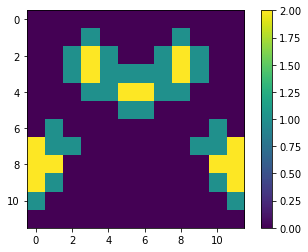

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from agent import game_logic

str_step = "010"
player_id = 0
with open(f'snapshots/game_state-{str_step}-{player_id}.pkl', 'rb') as handle:
    game_state = pickle.load(handle)
with open(f'snapshots/missions-{str_step}-{player_id}.pkl', 'rb') as handle:
    missions = pickle.load(handle)

game_logic(game_state, missions, DEBUG=True)
plt.imshow(game_state.convolved_collectable_tiles_matrix)
plt.colorbar()
plt.show()

# Make Submission

In [17]:
!rm snapshots/*.pkl
!tar --exclude='*.ipynb' --exclude="*.pyc" --exclude="*.pkl" -czf submission.tar.gz *
!rm *.py && rm -rf __pycache__/ && rm -rf lux/